In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.gaussian_process as gp
from scipy.integrate import solve_ivp
import scipy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sur_data import rw_metropolis_hastings

In [3]:
%matplotlib notebook
plt.style.use('seaborn')

### Forward model

In [7]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    dy[0] = a*y[0]-b*y[0]*y[1]
    dy[1] = d*y[0]*y[1]-c*y[1]
    return dy

In [8]:
def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

# Using Multiple Noisy Observations

### Case 0: Standard MCMC, no GP

In [201]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T = np.linspace(0,10,11)
y = solve_lv(T,y0,a,b,c,d)

# add noise multiple times
n_traj = 20 # number of different noise profiles
sigma = 0.05
Y_noisy = np.abs(y + sigma*np.random.randn(n_traj,y.shape[0],y.shape[1]))

In [202]:
# define likelihood and prior
# gaussian likelihood
def llh_std(y):
    return -((y-Y_noisy)**2).sum()

# uniform prior
def lpr_std(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_std(x):
    return solve_lv(T,x[:2],1,x[2],x[3],1)

In [203]:
# sample
x0 = np.array([2,.5,1,1])
cov = .03*np.eye(4)
X_std = rw_metropolis_hastings(f_std,llh_std,lpr_std,cov,x0,n=20000,burn_in=10000,update=False,verbose=False)

acceptance rate: 0.00565


In [204]:
kdes_std = []
for col in X_std.T:
    kdes_std.append(gaussian_kde(col))

### Case 1: directly fit to multiple simulated observations with same parameters

In [56]:
# fit gaussian processes
kernel1 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel()
kernel2 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel()
y1_gp = gp.GaussianProcessRegressor(kernel1)
y2_gp = gp.GaussianProcessRegressor(kernel2)
T_train = np.repeat(T[np.newaxis],n_traj,axis=0).flatten()[:,np.newaxis]
y1_gp = y1_gp.fit(T_train,Y_noisy[:,0].flatten())
y2_gp = y2_gp.fit(T_train,Y_noisy[:,1].flatten())

In [252]:
# define high-res time points for evaluation
T_sur = np.linspace(0,10,201)

# compute mean and covariance of GPs
mean1,cov1 = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2 = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)

#symmytrize
cov1 = .5*(cov1+cov1.T)
cov2 = .5*(cov2+cov2.T)

# compute eigendecompositions
e1,v1 = la.eig(cov1)
e2,v2 = la.eig(cov2)

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

In [253]:
np.max(np.abs(v1@np.diag(e1)@v1.T-cov1))

4.807038705964206e-05

$AV = V\Lambda$

<IPython.core.display.Javascript object>


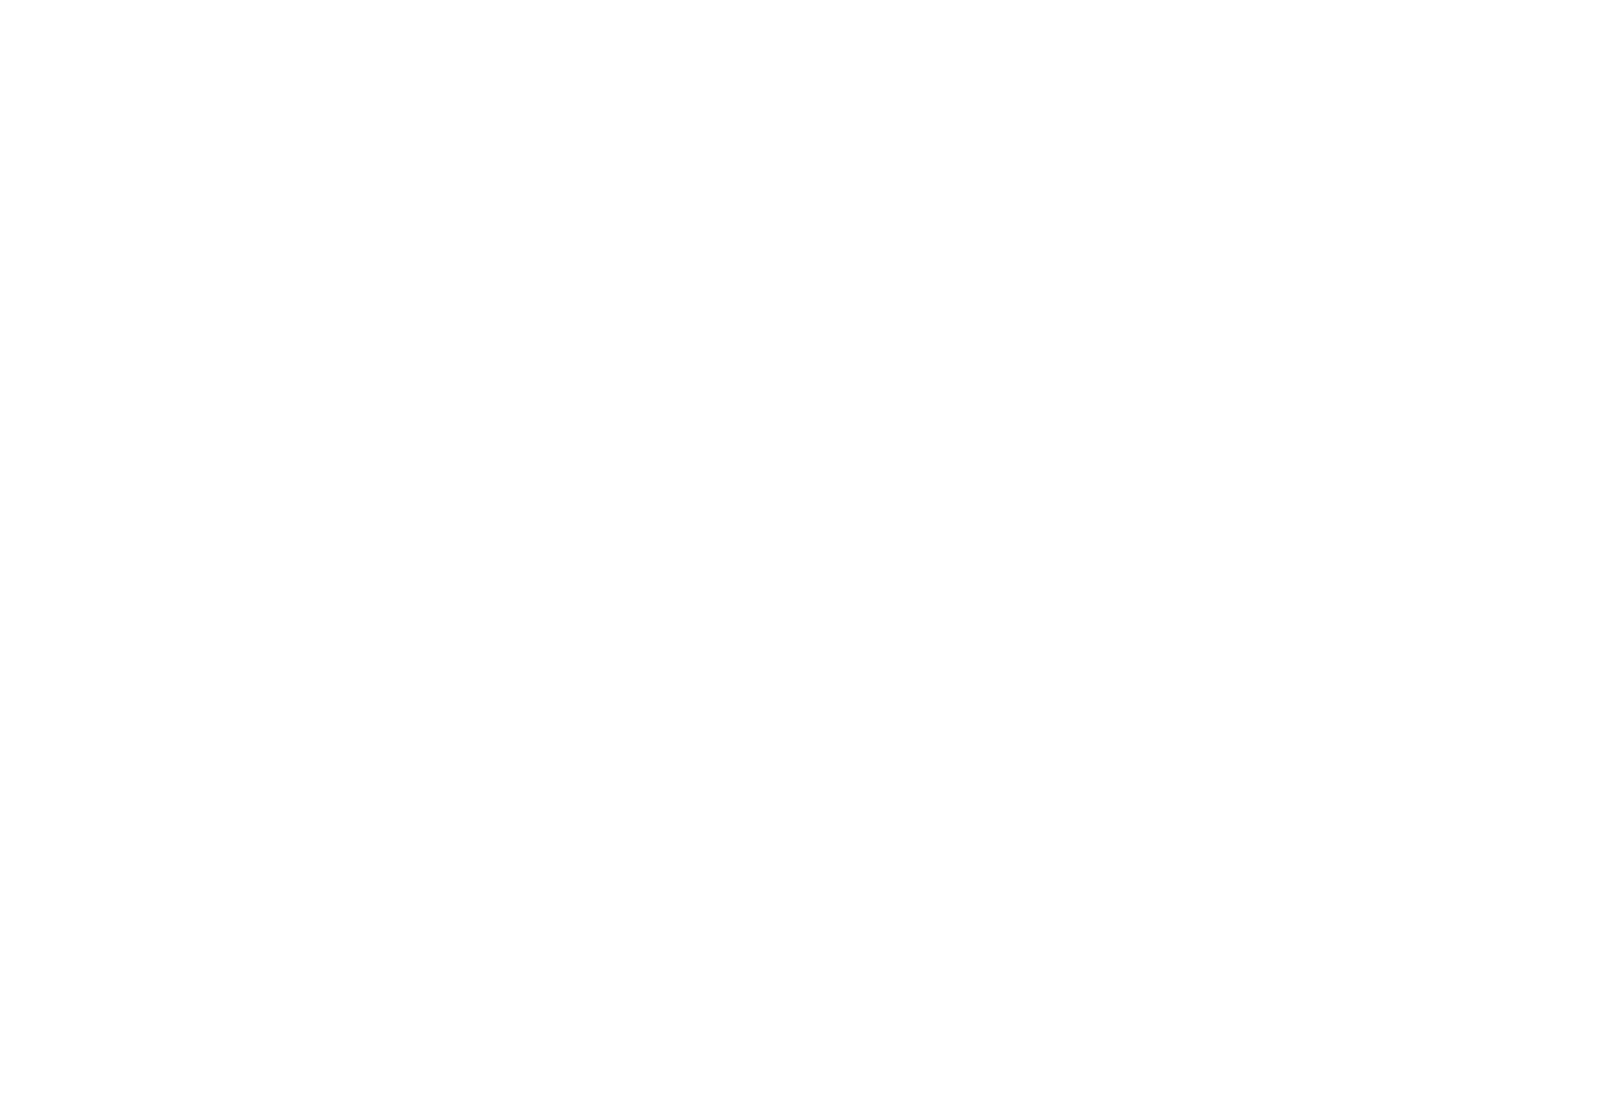

<IPython.core.display.Javascript object>


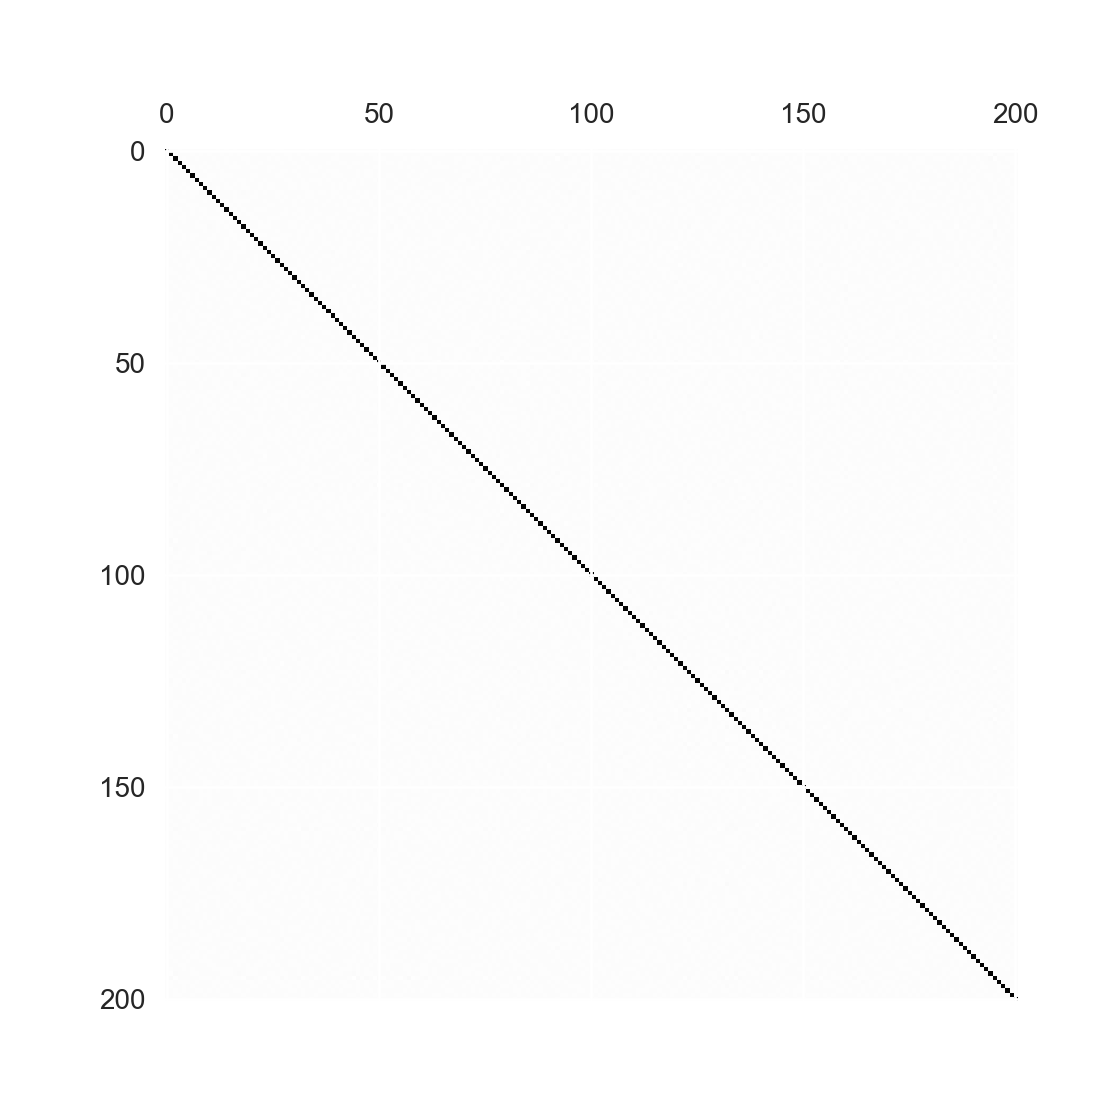

In [254]:
plt.figure()
plt.matshow(W1.T@(W1)@cov1)
plt.show()

In [255]:
np.max(np.abs((W1.T@(W1)@cov1-np.eye(len(cov1)))))

0.020965488589065676

In [58]:
# high res simulation
y_hr = solve_lv(T_sur,y0,a,b,c,d)

<IPython.core.display.Javascript object>


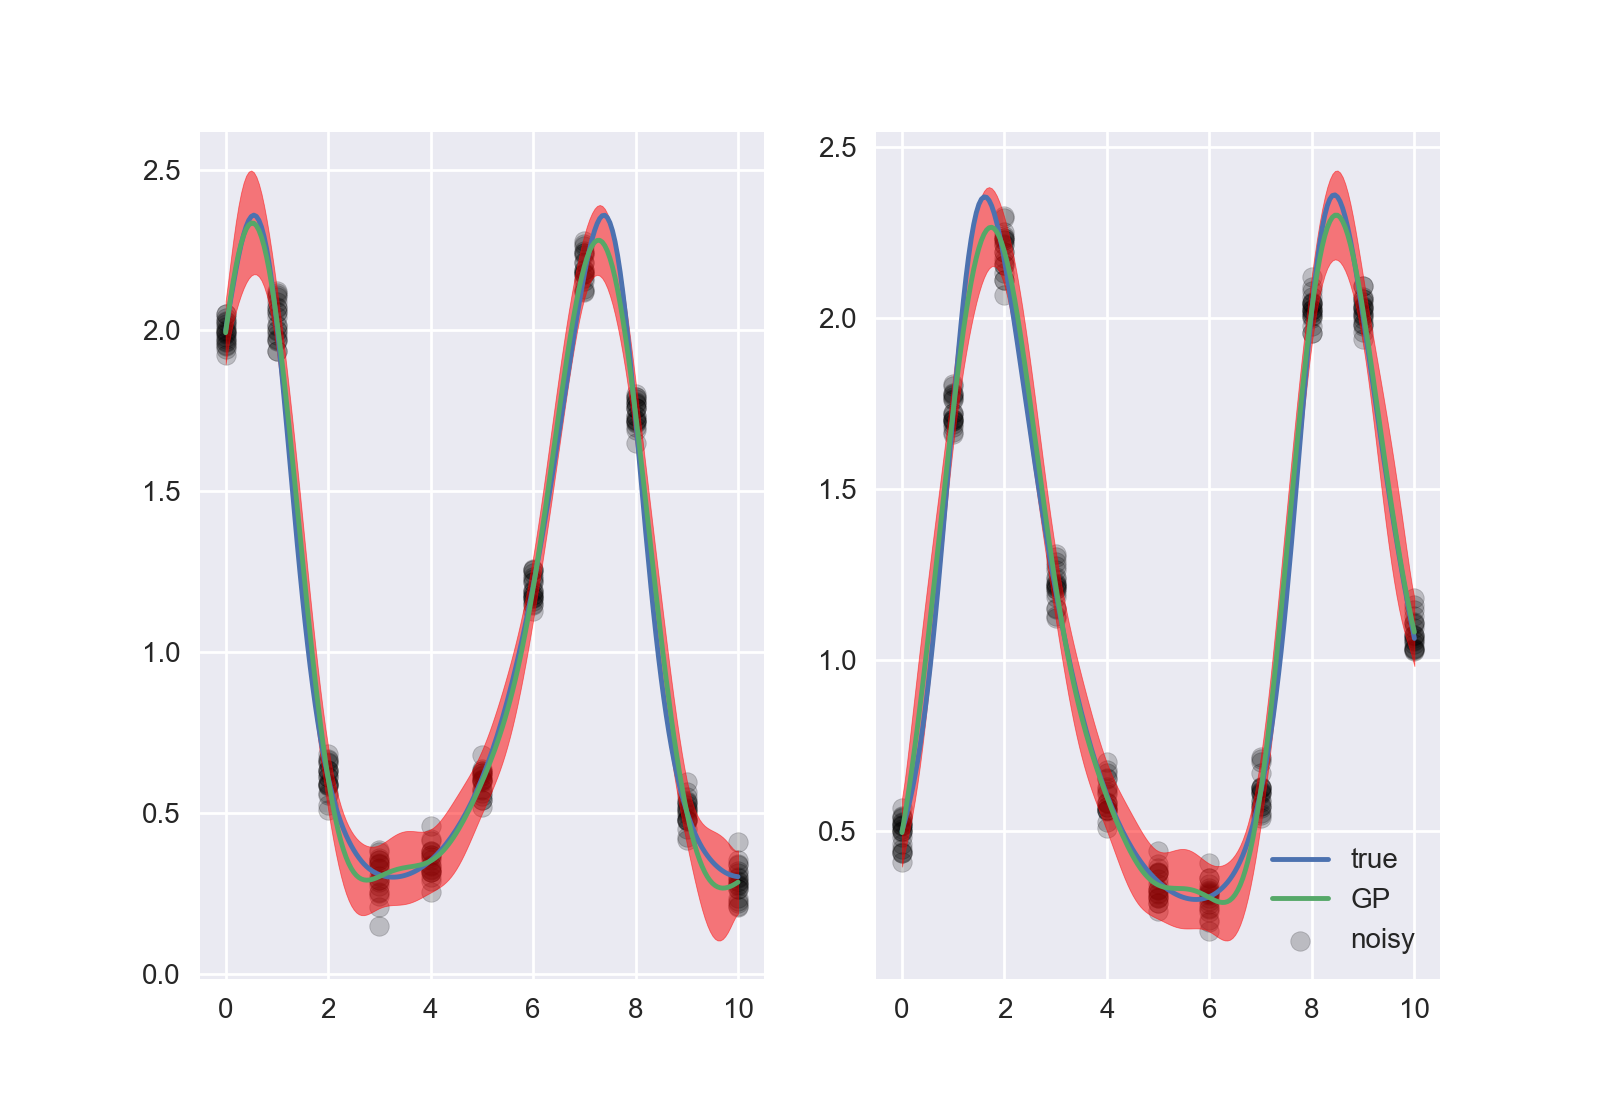

In [59]:
fig = plt.figure()
plt.subplot(121)
plt.plot(T_sur,y_hr[0],label='true')
plt.scatter(T_train.flatten(),Y_noisy[:,0].flatten(),c='k',label='noisy',alpha=.2)
plt.plot(T_sur,mean1,label='GP')
plt.fill_between(T_sur,mean1-2*np.sqrt(np.diag(cov1)),mean1+2*np.sqrt(np.diag(cov1)),color='r',alpha=.5)
plt.subplot(122)
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T_train.flatten(),Y_noisy[:,1].flatten(),c='k',label='noisy',alpha=.2)
plt.plot(T_sur,mean2,label='GP')
plt.fill_between(T_sur,mean2-2*np.sqrt(np.diag(cov2)),mean2+2*np.sqrt(np.diag(cov2)),color='r',alpha=.5)
plt.legend()
plt.show()

In [118]:
# define likelihood and prior
# gaussian likelihood
def llh_sur(y):
    return -la.norm(W1@(y[0]-mean1))**2 - la.norm(W2@(y[1]-mean2))**2

# uniform prior
def lpr_sur(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_sur(x):
    return solve_lv(T_sur,x[:2],1,x[2],x[3],1)

In [90]:
# sample
x0 = np.array([1.5,.5,1,1])
cov = 0.0000001*np.eye(4)
X,lpr,llh = rw_metropolis_hastings(f_sur,llh_sur,lpr_sur,cov,x0,n=10000,burn_in=10000,debug=True)

acceptance rate: 0.0179


<IPython.core.display.Javascript object>


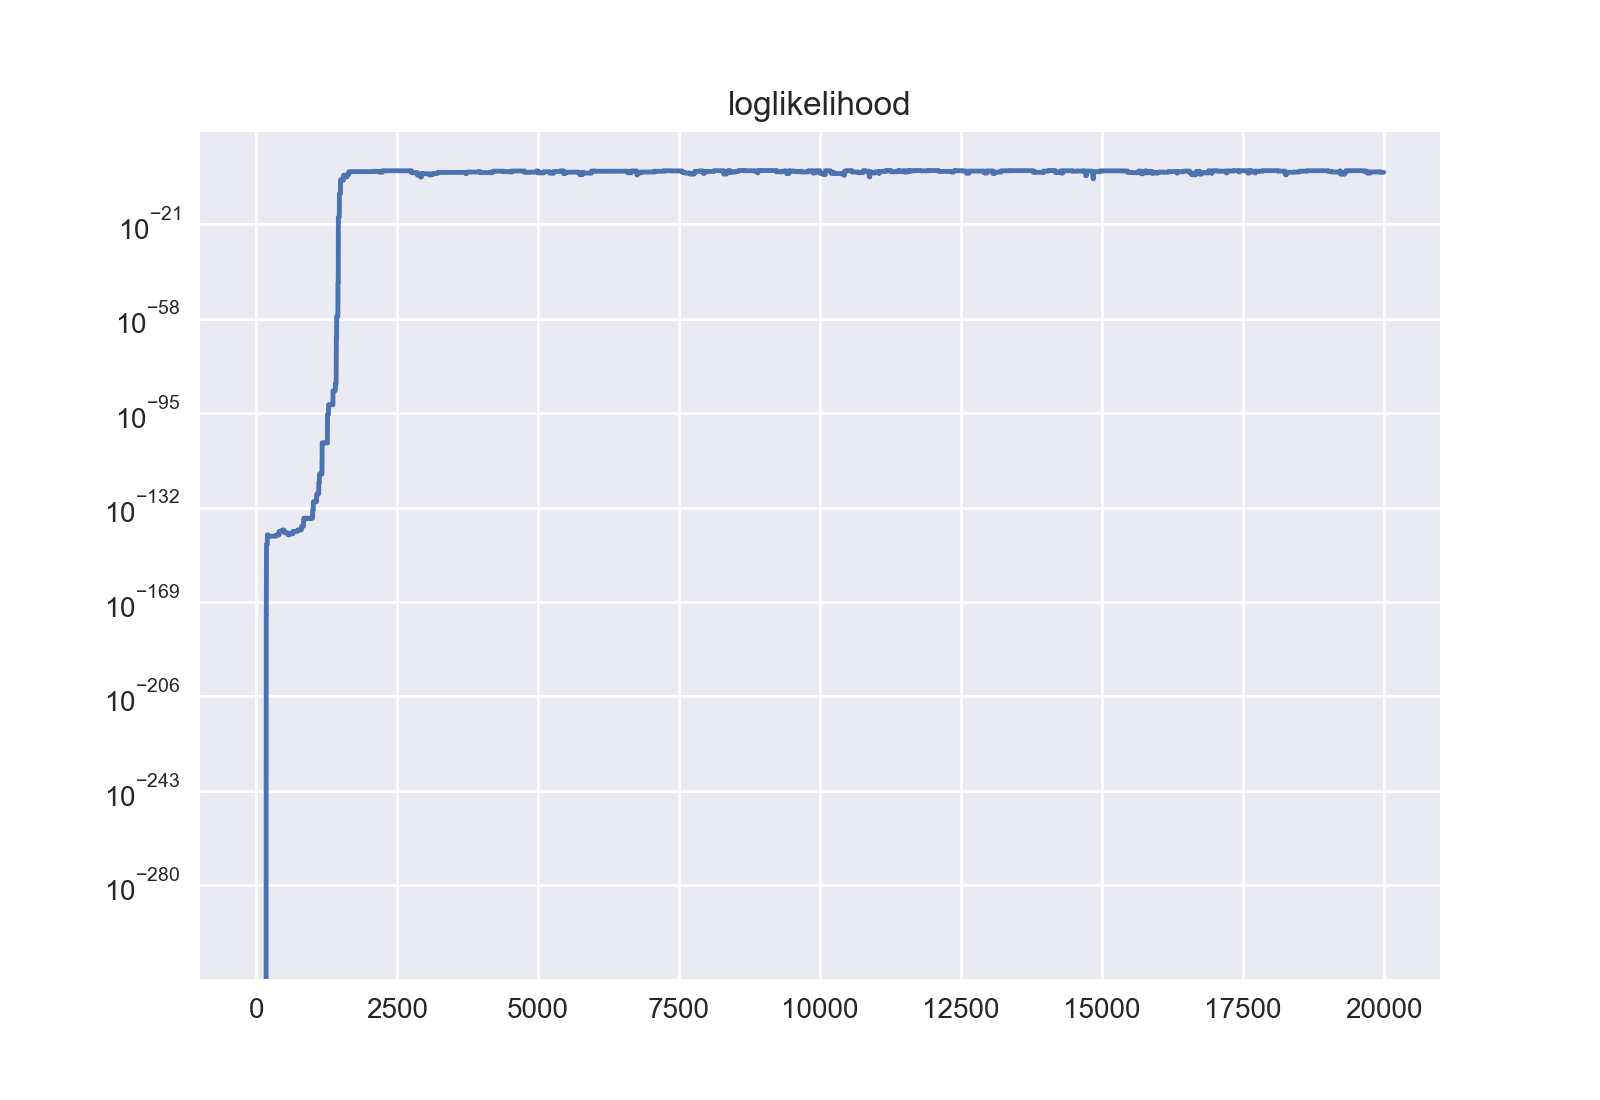

In [91]:
fig = plt.figure()
plt.semilogy(np.exp(llh))
plt.title('loglikelihood')
plt.show()

<IPython.core.display.Javascript object>


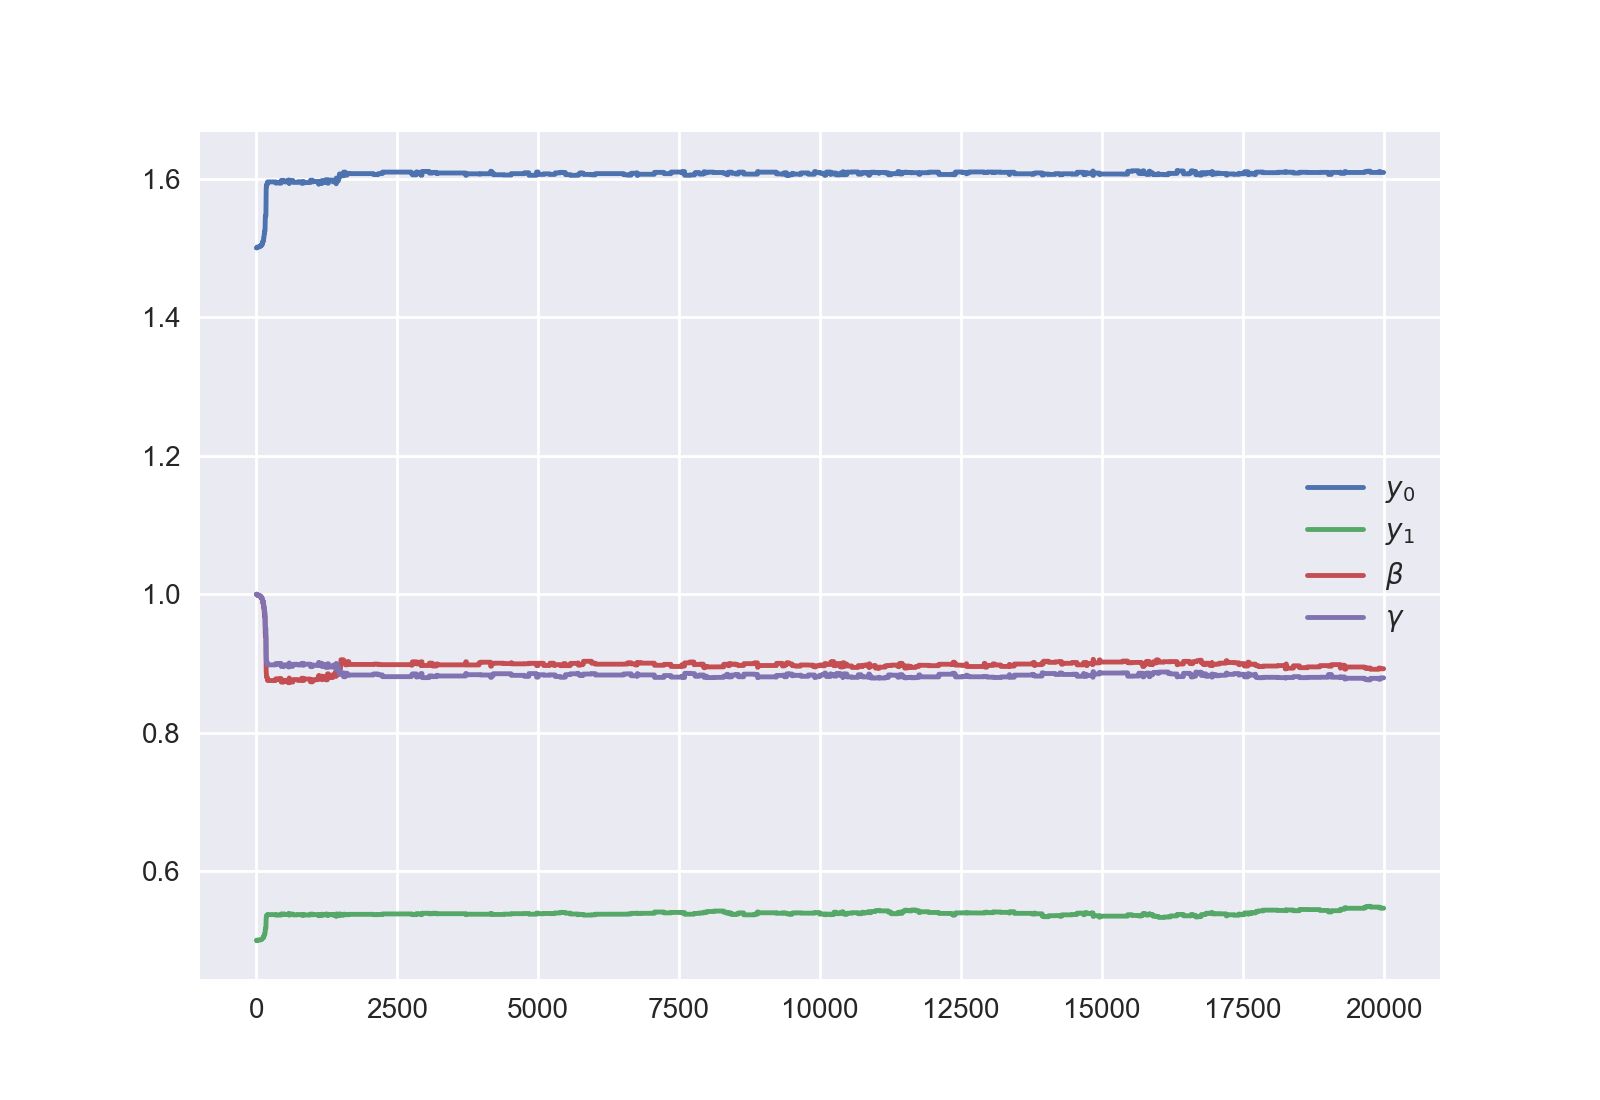

In [92]:
fig = plt.figure()
lines = plt.plot(X)
plt.legend(lines,['$y_0$','$y_1$','$\\beta$','$\\gamma$'])
plt.show()

In [95]:
x_hat = np.mean(X,axis=0)

<IPython.core.display.Javascript object>


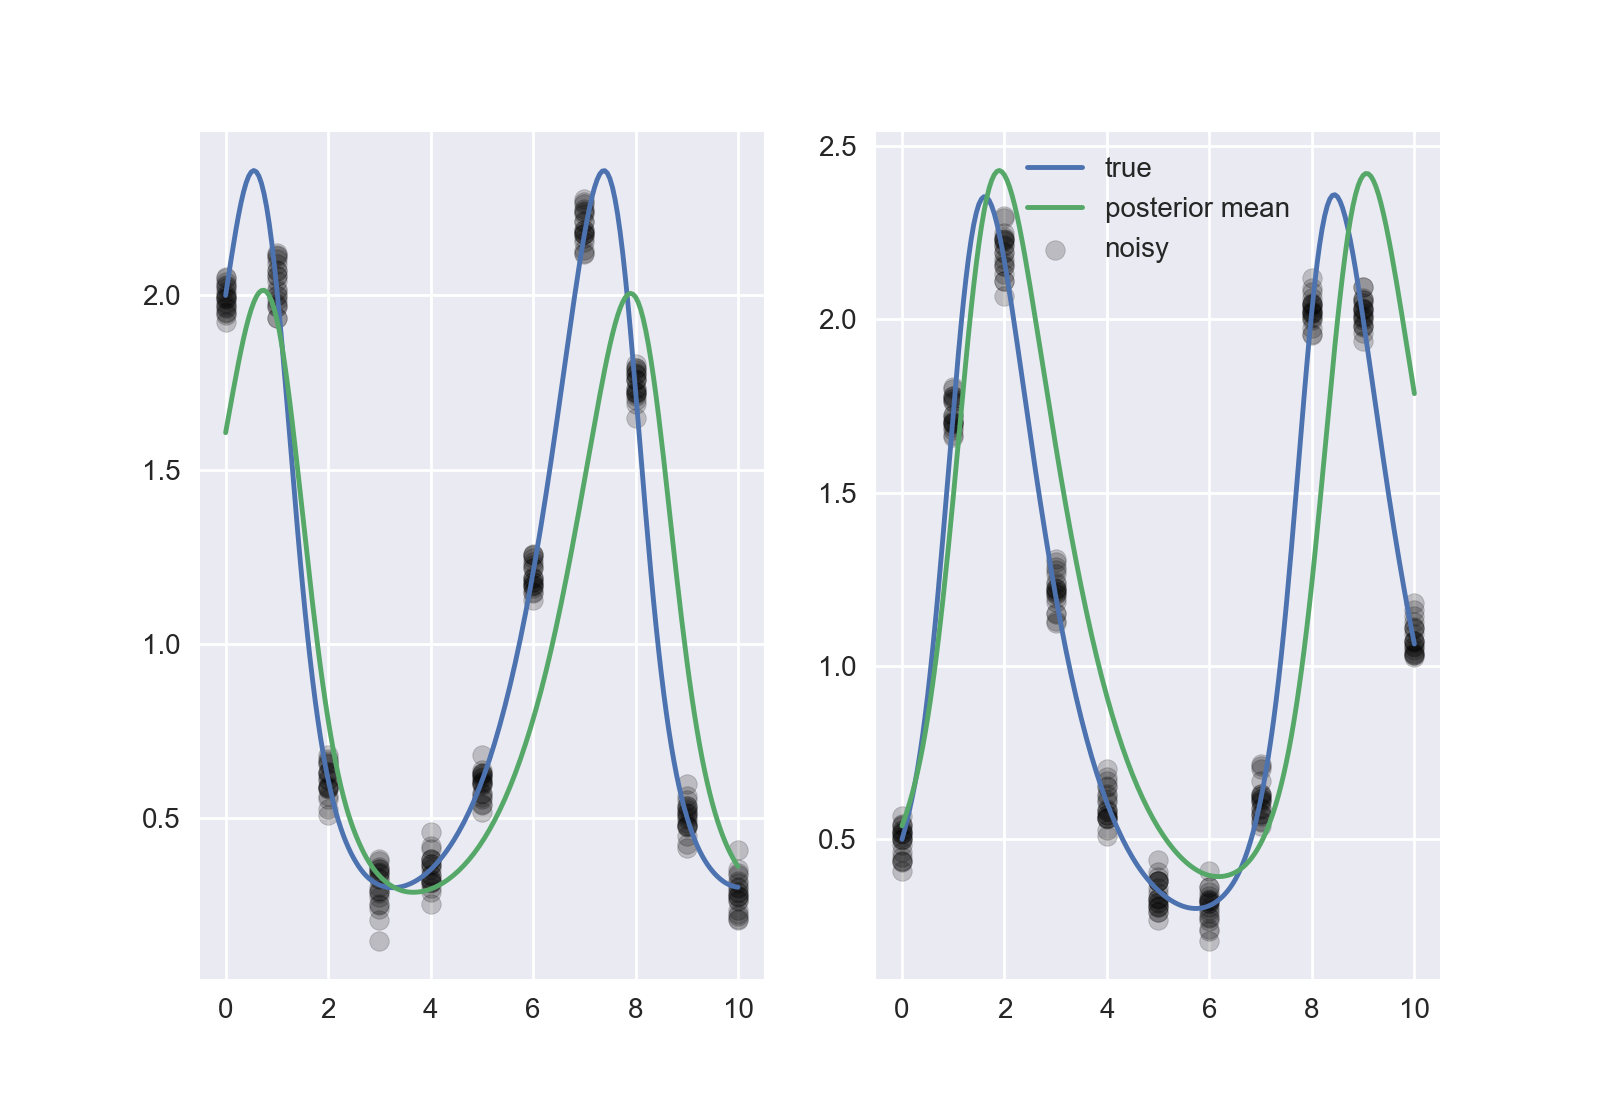

In [97]:
y_hat = f_sur(x_hat)
fig = plt.figure()
plt.subplot(121)
plt.plot(T_sur,y_hr[0],label='true')
plt.scatter(T_train.flatten(),Y_noisy[:,0].flatten(),c='k',label='noisy',alpha=.2)
plt.plot(T_sur,y_hat[0],label='posterior mean')
plt.subplot(122)
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T_train.flatten(),Y_noisy[:,1].flatten(),c='k',label='noisy',alpha=.2)
plt.plot(T_sur,y_hat[1],label='posterior mean')
plt.legend()
plt.show()

In [123]:
y_true = f_sur([2,.5,1,1])

In [124]:
llh_sur(y_true)

-149.7421972007919

In [125]:
llh[-1]

-1.6229450415279287

In [126]:
X[-1]

array([1.60897458, 0.54664395, 0.89235329, 0.87924106])

In [104]:
Y_samp = y1_gp.sample_y(T_sur[:,np.newaxis],10)

<IPython.core.display.Javascript object>


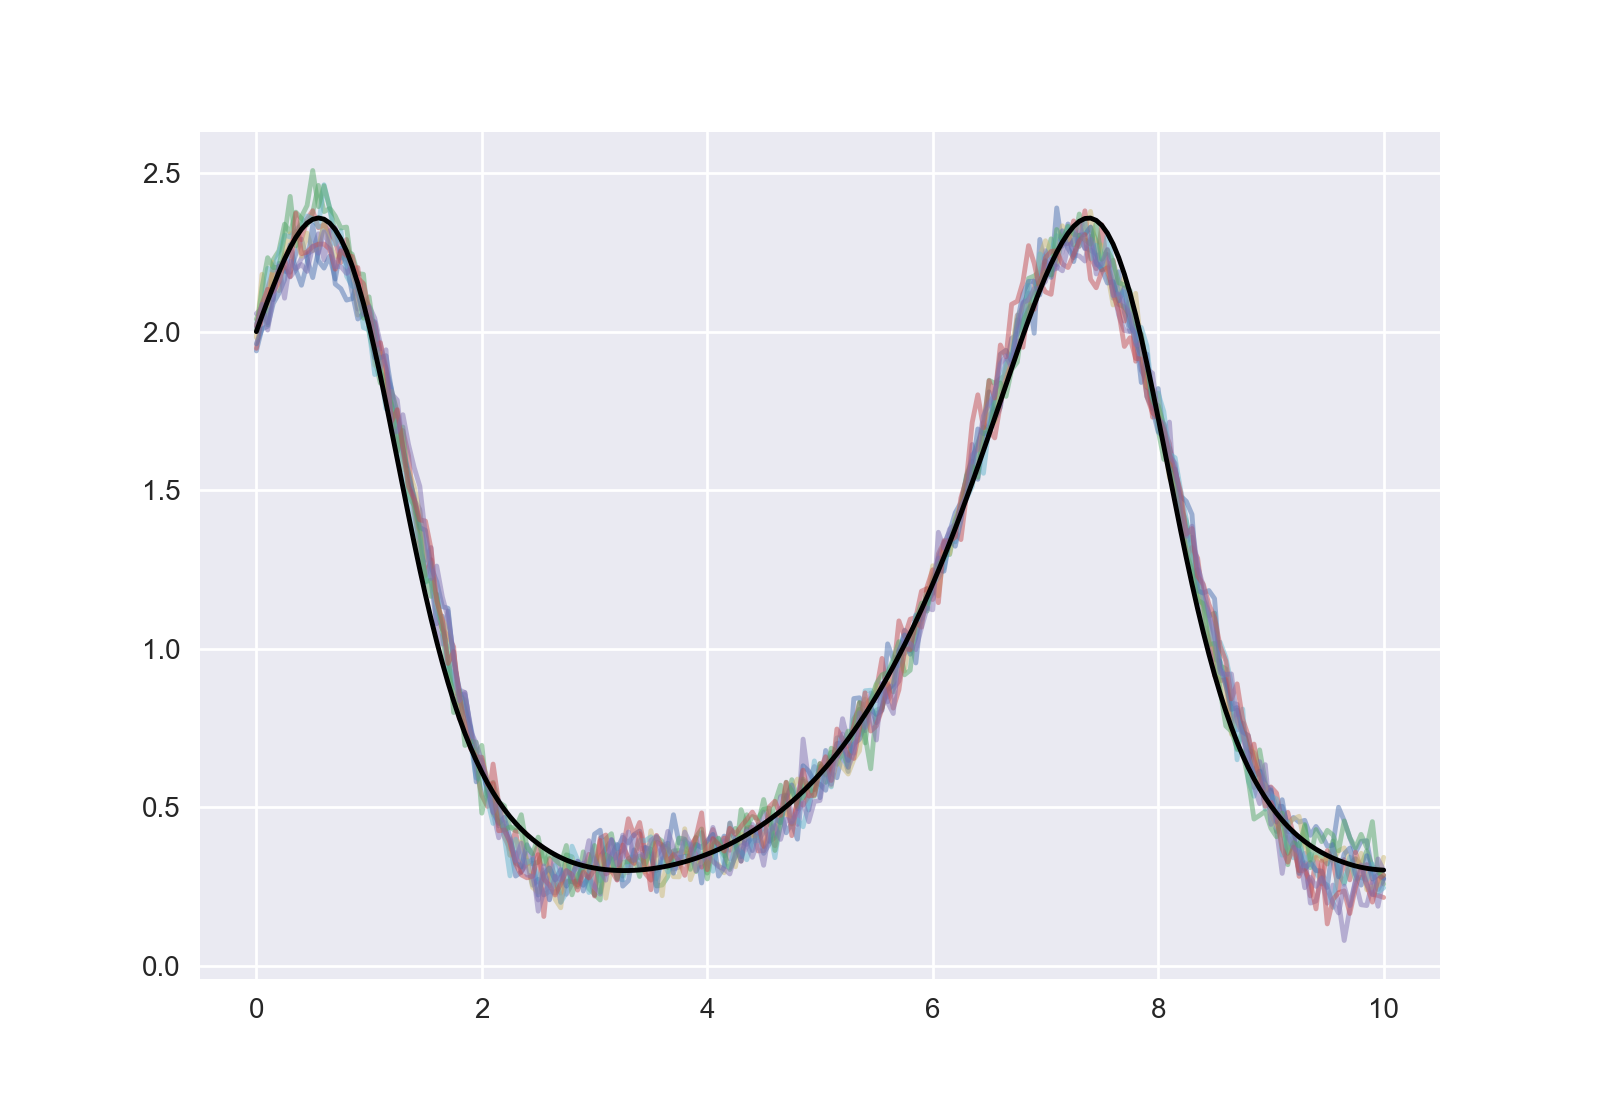

In [109]:
fig = plt.figure()
for row in Y_samp.T:
    plt.plot(T_sur,row,alpha=.5)
plt.plot(T_sur,y_hr[0],c='k')
plt.show()

In [186]:
# gridsearch
n = 20
y0_ = np.linspace(1.5,2.5,n)
y1_ = np.linspace(.25,.75,n)
beta_ = np.linspace(.75,1.25,n)
gamma_ = np.linspace(.75,1.25,n)
LLH1 = np.empty((n,n,n,n))
LLH2 = np.empty((n,n,n,n))
LLH3 = np.empty((n,n,n,n))
for i in range(len(y0_)):
    print(f"i={i}")
    for j in range(len(y1_)):
        for k in range(len(beta_)):
            for l in range(len(gamma_)):
                u = f_sur([y0_[i],y1_[j],beta_[k],gamma_[l]])
                LLH1[i,j,k,l] = llh_sur(u)
                LLH2[i,j,k,l] = llh_sur2(u)
                u = f_std([y0_[i],y1_[j],beta_[k],gamma_[l]])
                LLH3[i,j,k,l] = llh_std(u)

i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19


In [218]:
# compute probability densities
pdf1 = np.exp(LLH1)
pdf2 = np.exp(LLH2)
pdf3 = np.exp(LLH3)

<IPython.core.display.Javascript object>


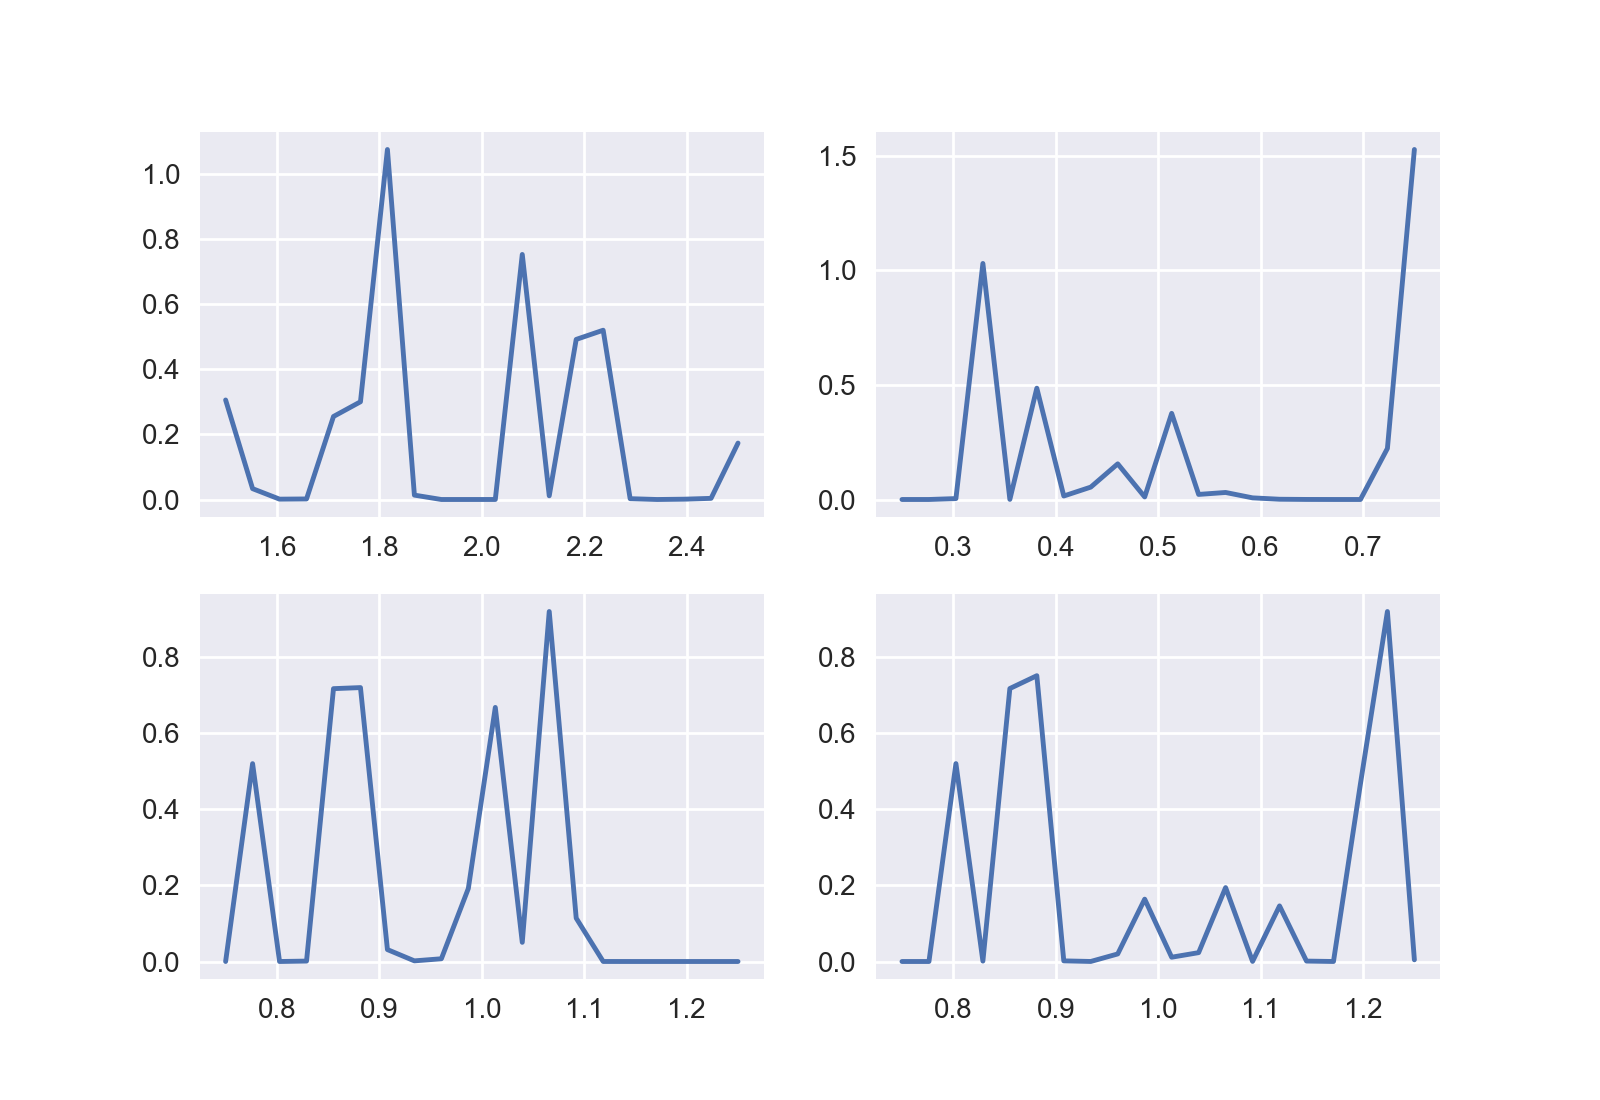

In [188]:
fig = plt.figure()
plt.subplot(221)
plt.plot(y0_,pdf1.sum(axis=(1,2,3)))
plt.subplot(222)
plt.plot(y1_,pdf1.sum(axis=(0,2,3)))
plt.subplot(223)
plt.plot(beta_,pdf1.sum(axis=(0,1,3)))
plt.subplot(224)
plt.plot(gamma_,pdf1.sum(axis=(0,1,2)))
plt.show()

<IPython.core.display.Javascript object>


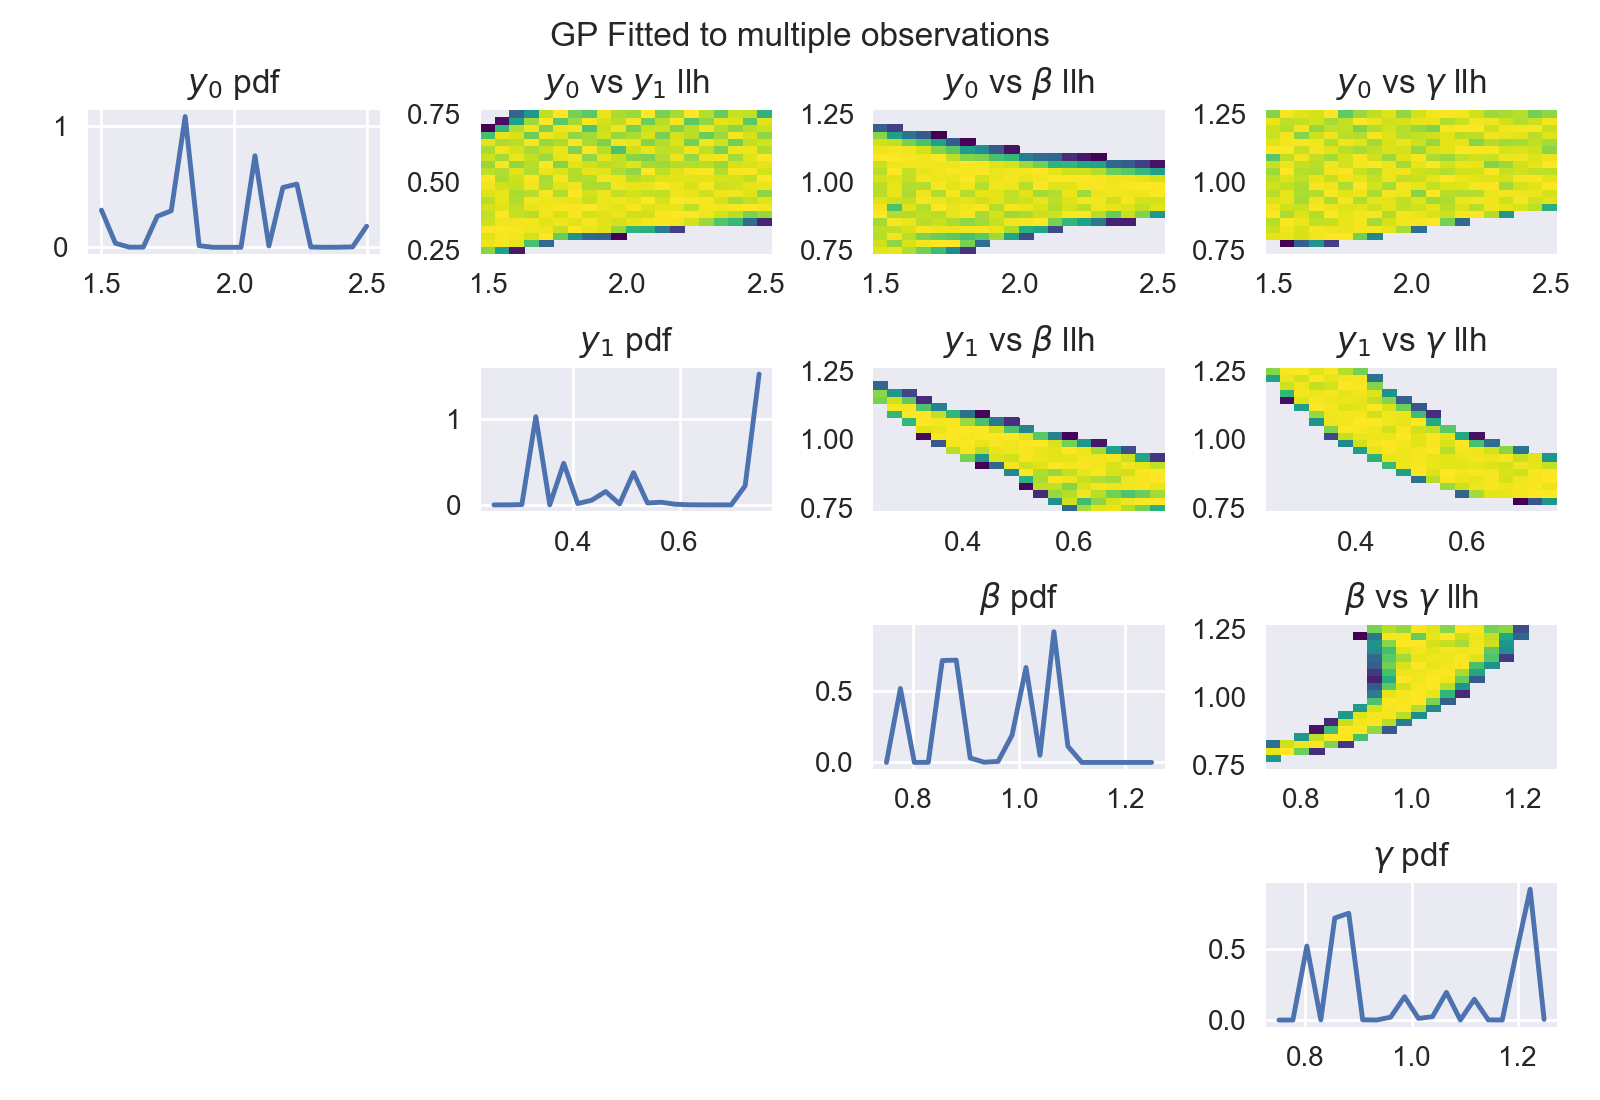

<ipython-input-219-d84c4de0cf03>:9: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
<ipython-input-219-d84c4de0cf03>:13: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
<ipython-input-219-d84c4de0cf03>:17: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
<ipython-input-219-d84c4de0cf03>:25: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
<ipython-input-219-d84c4de0cf03>:29: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
<ipython-input-219-d84c4de0cf03>:37: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='

In [219]:
data = pdf1

fig = plt.figure()
plt.subplot(441)
plt.plot(y0_,data.sum(axis=(1,2,3)))
plt.title('$y_0$ pdf')
plt.subplot(442)
X,Y = np.meshgrid(y0_,y1_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $y_1$ llh')
plt.subplot(443)
X,Y = np.meshgrid(y0_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\beta$ llh')
plt.subplot(444)
X,Y = np.meshgrid(y0_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\gamma$ llh')

plt.subplot(446)
plt.plot(y1_,data.sum(axis=(0,2,3)))
plt.title('$y_1$ pdf')
plt.subplot(447)
X,Y = np.meshgrid(y1_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\beta$ llh')
plt.subplot(448)
X,Y = np.meshgrid(y1_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\gamma$ llh')

plt.subplot(4,4,11)
plt.plot(beta_,data.sum(axis=(0,1,3)))
plt.title('$\\beta$ pdf')
plt.subplot(4,4,12)
X,Y = np.meshgrid(beta_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')
plt.title('$\\beta$ vs $\\gamma$ llh')

plt.subplot(4,4,16)
plt.plot(gamma_,data.sum(axis=(0,1,2)))
plt.title('$\\gamma$ pdf')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("GP Fitted to multiple observations")
plt.show()

<IPython.core.display.Javascript object>


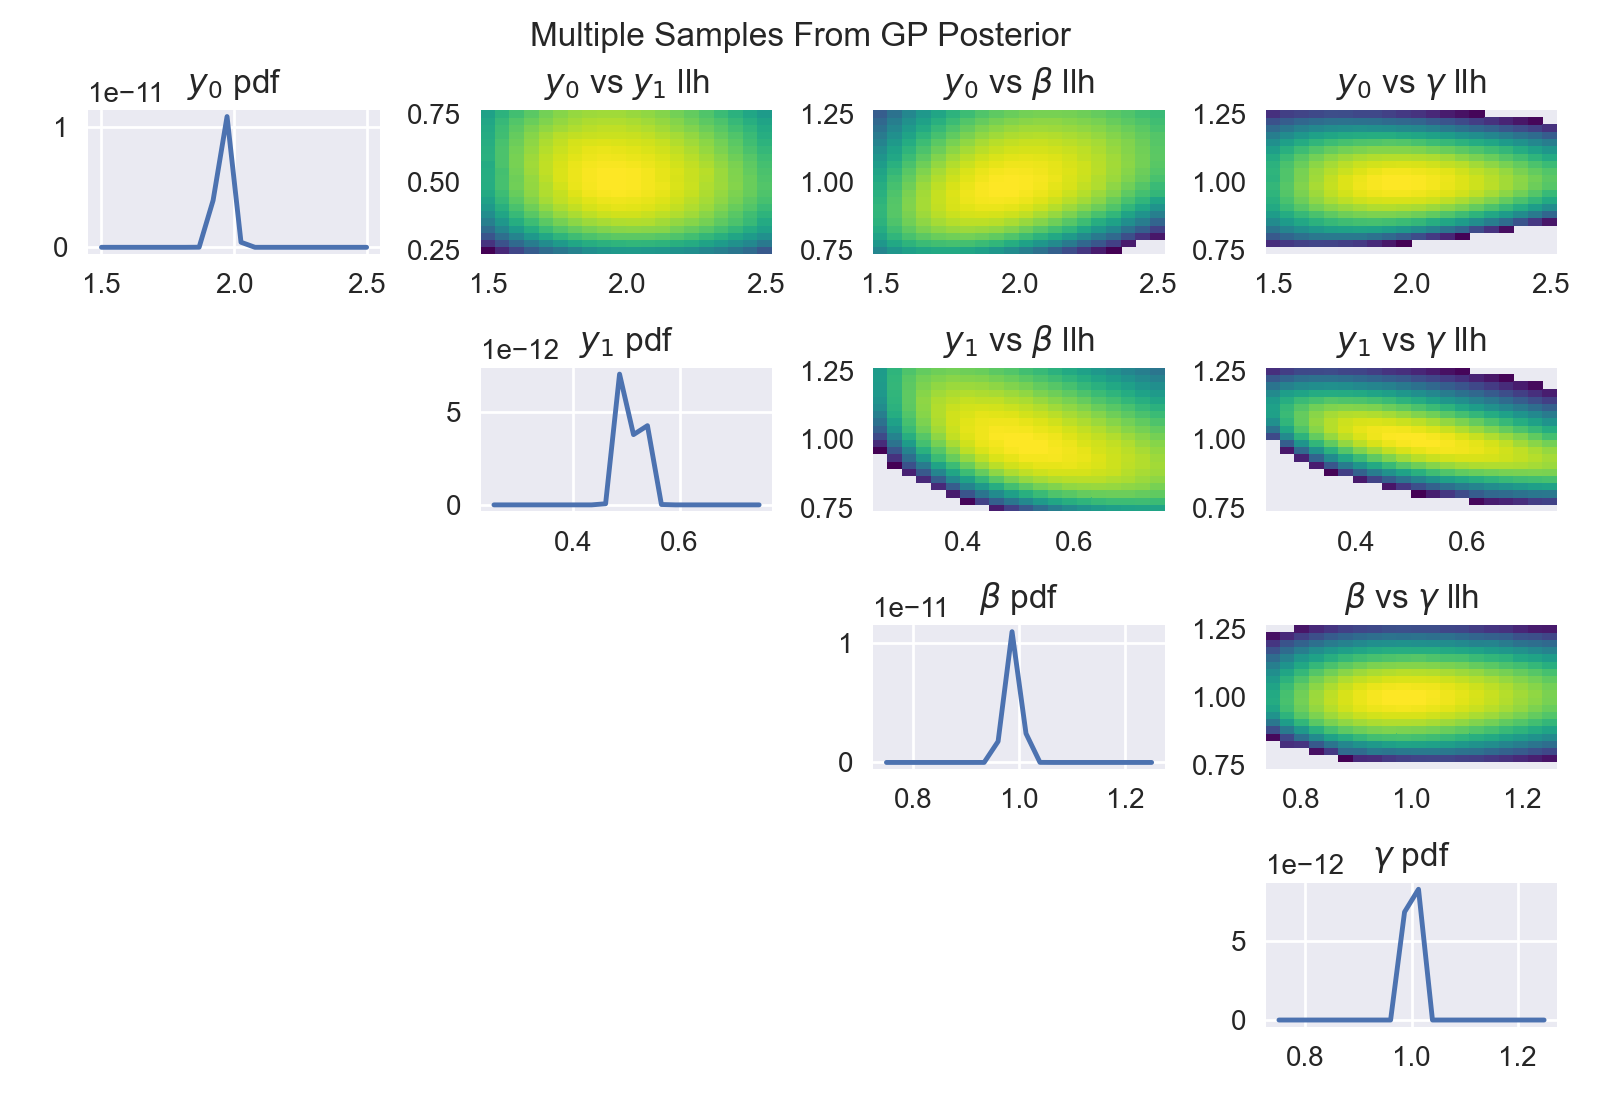

<ipython-input-220-47b1795c8617>:13: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
<ipython-input-220-47b1795c8617>:17: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
<ipython-input-220-47b1795c8617>:25: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
<ipython-input-220-47b1795c8617>:29: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
<ipython-input-220-47b1795c8617>:37: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')


In [220]:
data = pdf2

fig = plt.figure()
plt.subplot(441)
plt.plot(y0_,data.sum(axis=(1,2,3)))
plt.title('$y_0$ pdf')
plt.subplot(442)
X,Y = np.meshgrid(y0_,y1_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $y_1$ llh')
plt.subplot(443)
X,Y = np.meshgrid(y0_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\beta$ llh')
plt.subplot(444)
X,Y = np.meshgrid(y0_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\gamma$ llh')

plt.subplot(446)
plt.plot(y1_,data.sum(axis=(0,2,3)))
plt.title('$y_1$ pdf')
plt.subplot(447)
X,Y = np.meshgrid(y1_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\beta$ llh')
plt.subplot(448)
X,Y = np.meshgrid(y1_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\gamma$ llh')

plt.subplot(4,4,11)
plt.plot(beta_,data.sum(axis=(0,1,3)))
plt.title('$\\beta$ pdf')
plt.subplot(4,4,12)
X,Y = np.meshgrid(beta_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')
plt.title('$\\beta$ vs $\\gamma$ llh')

plt.subplot(4,4,16)
plt.plot(gamma_,data.sum(axis=(0,1,2)))
plt.title('$\\gamma$ pdf')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Multiple Samples From GP Posterior")
plt.show()

<IPython.core.display.Javascript object>


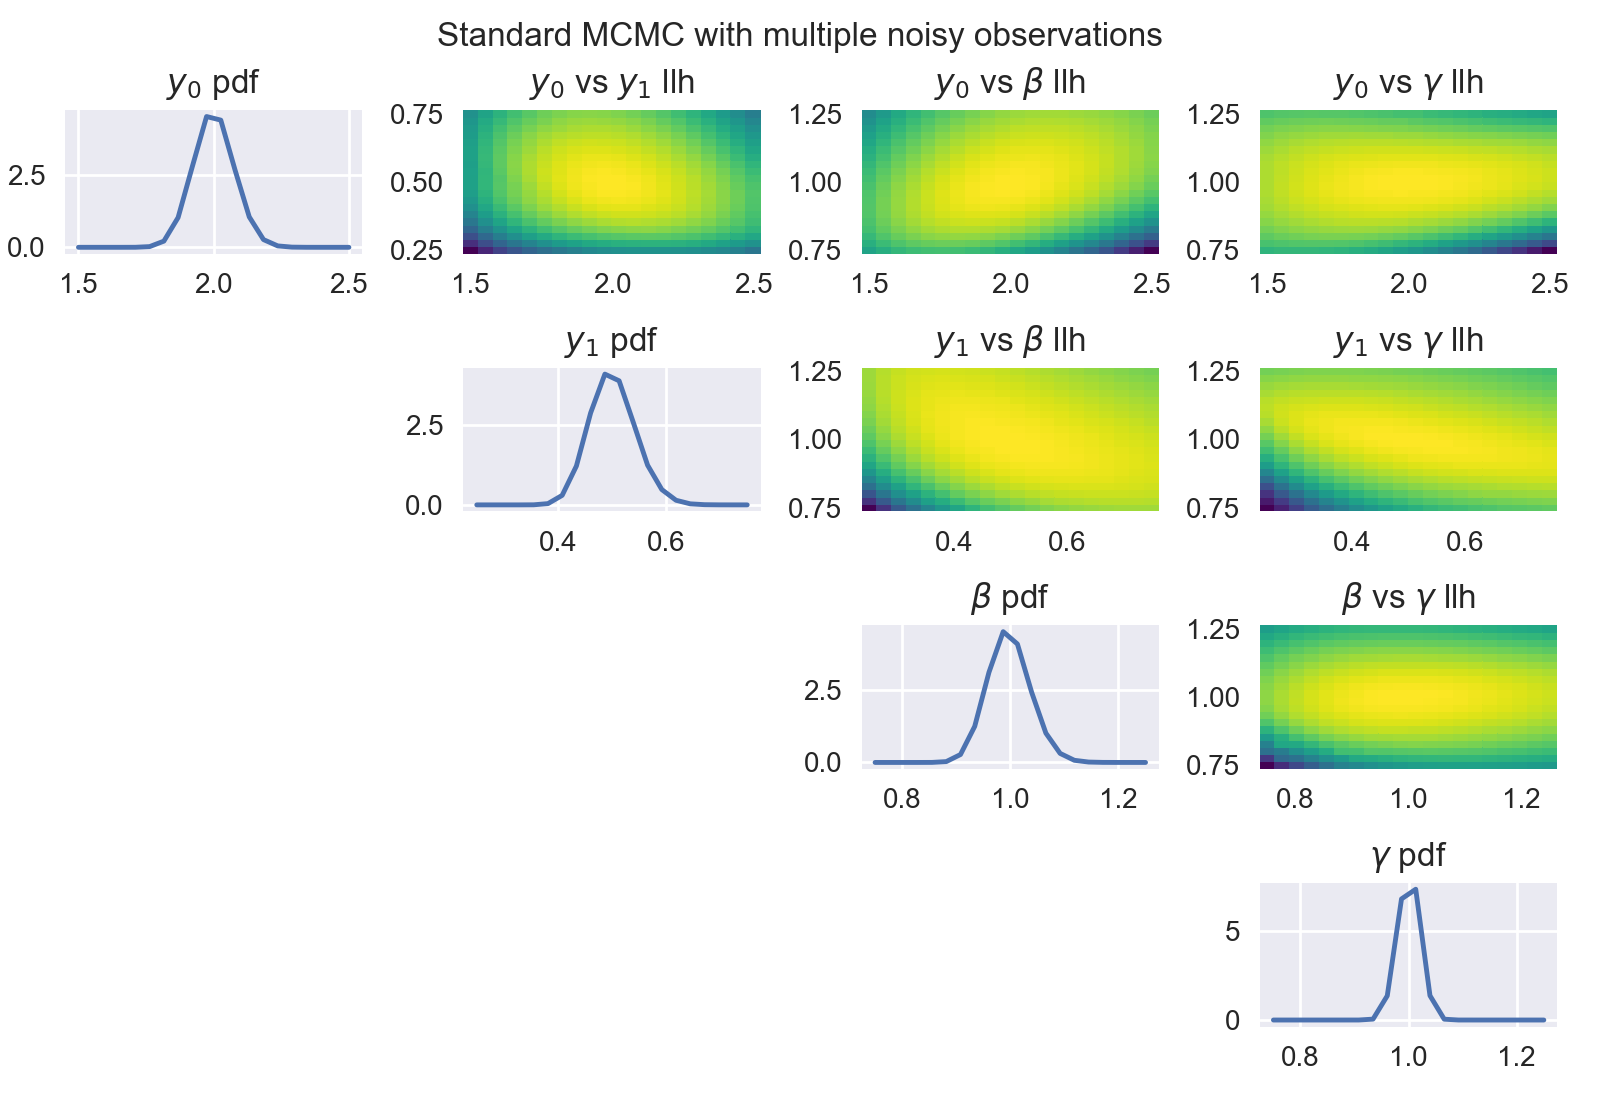

In [221]:
data = pdf3

fig = plt.figure()
plt.subplot(441)
plt.plot(y0_,data.sum(axis=(1,2,3)))
plt.title('$y_0$ pdf')
plt.subplot(442)
X,Y = np.meshgrid(y0_,y1_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(2,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $y_1$ llh')
plt.subplot(443)
X,Y = np.meshgrid(y0_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,3))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\beta$ llh')
plt.subplot(444)
X,Y = np.meshgrid(y0_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(1,2))),cmap='viridis',shading='auto')
plt.title('$y_0$ vs $\\gamma$ llh')

plt.subplot(446)
plt.plot(y1_,data.sum(axis=(0,2,3)))
plt.title('$y_1$ pdf')
plt.subplot(447)
X,Y = np.meshgrid(y1_,beta_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,3))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\beta$ llh')
plt.subplot(448)
X,Y = np.meshgrid(y1_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,2))),cmap='viridis',shading='auto')
plt.title('$y_1$ vs $\\gamma$ llh')

plt.subplot(4,4,11)
plt.plot(beta_,data.sum(axis=(0,1,3)))
plt.title('$\\beta$ pdf')
plt.subplot(4,4,12)
X,Y = np.meshgrid(beta_,gamma_,indexing='ij')
plt.pcolormesh(X,Y,np.log(data.sum(axis=(0,1))),cmap='viridis',shading='auto')
plt.title('$\\beta$ vs $\\gamma$ llh')

plt.subplot(4,4,16)
plt.plot(gamma_,data.sum(axis=(0,1,2)))
plt.title('$\\gamma$ pdf')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Standard MCMC with multiple noisy observations")
plt.show()

<IPython.core.display.Javascript object>


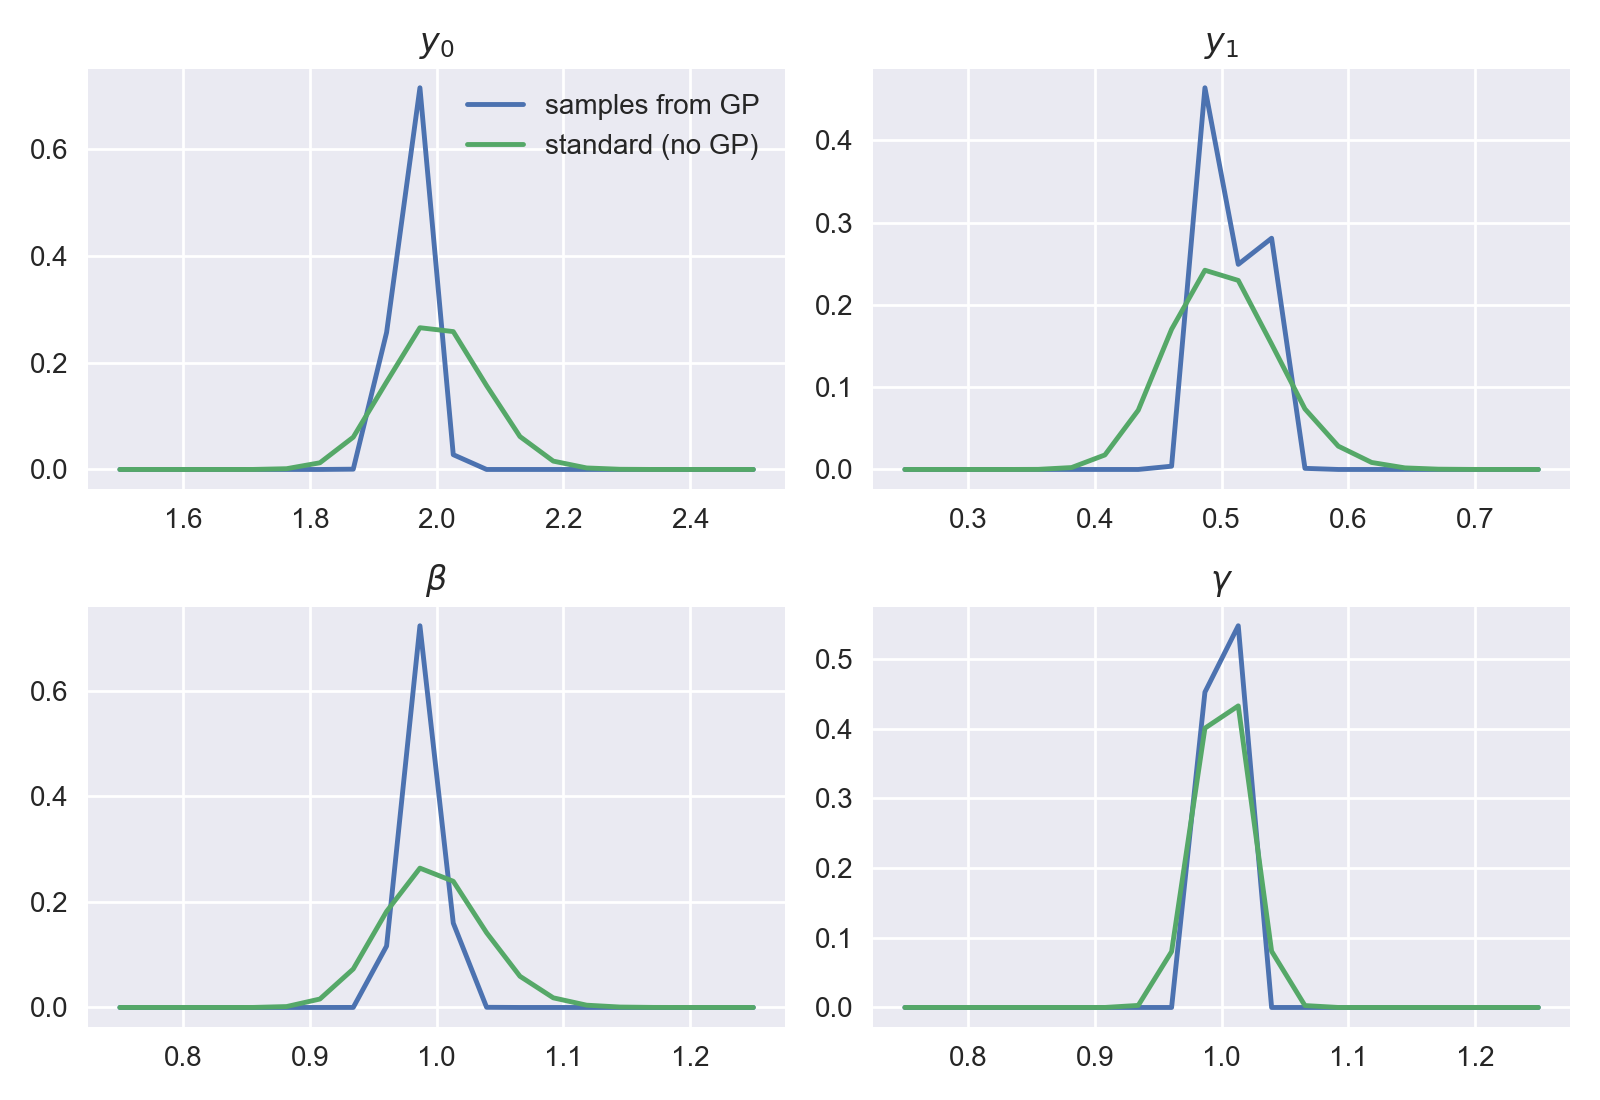

In [223]:
fig = plt.figure()
plt.subplot(221)
d1 = pdf2.sum(axis=(1,2,3))
d2 = pdf3.sum(axis=(1,2,3))
plt.plot(y0_,d1/d1.sum(),label="samples from GP")
plt.plot(y0_,d2/d2.sum(),label="standard (no GP)")
plt.legend()
plt.title("$y_0$")
plt.subplot(222)
d1 = pdf2.sum(axis=(0,2,3))
d2 = pdf3.sum(axis=(0,2,3))
plt.plot(y1_,d1/d1.sum())
plt.plot(y1_,d2/d2.sum())
plt.title("$y_1$")
plt.subplot(223)
d1 = pdf2.sum(axis=(0,1,3))
d2 = pdf3.sum(axis=(0,1,3))
plt.plot(beta_,d1/d1.sum())
plt.plot(beta_,d2/d2.sum())
plt.title("$\\beta$")
plt.subplot(224)
d1 = pdf2.sum(axis=(0,1,2))
d2 = pdf3.sum(axis=(0,1,2))
plt.plot(gamma_,d1/d1.sum())
plt.plot(gamma_,d2/d2.sum())
plt.title("$\\gamma$")

plt.tight_layout()
plt.show()

### Compare to samples from GP posterior

In [114]:
y1_samp = y1_gp.sample_y(T_sur[:,np.newaxis],10)
y2_samp = y2_gp.sample_y(T_sur[:,np.newaxis],10)

In [117]:
def llh_sur2(y):
    return -((y[0]-y1_samp.T)**2).sum()-((y[1]-y2_samp.T)**2).sum()

In [177]:
x0 = np.array([1.5,.5,1,1])
cov = 0.01*np.eye(4)
X_post,lpr,llh = rw_metropolis_hastings(f_sur,llh_sur2,lpr_sur,cov,x0,n=10000,burn_in=1000,debug=True)

acceptance rate: 0.1206


In [180]:
kdes_post = []
for col in X_post.T:
    kdes_post.append(gaussian_kde(col))

<IPython.core.display.Javascript object>


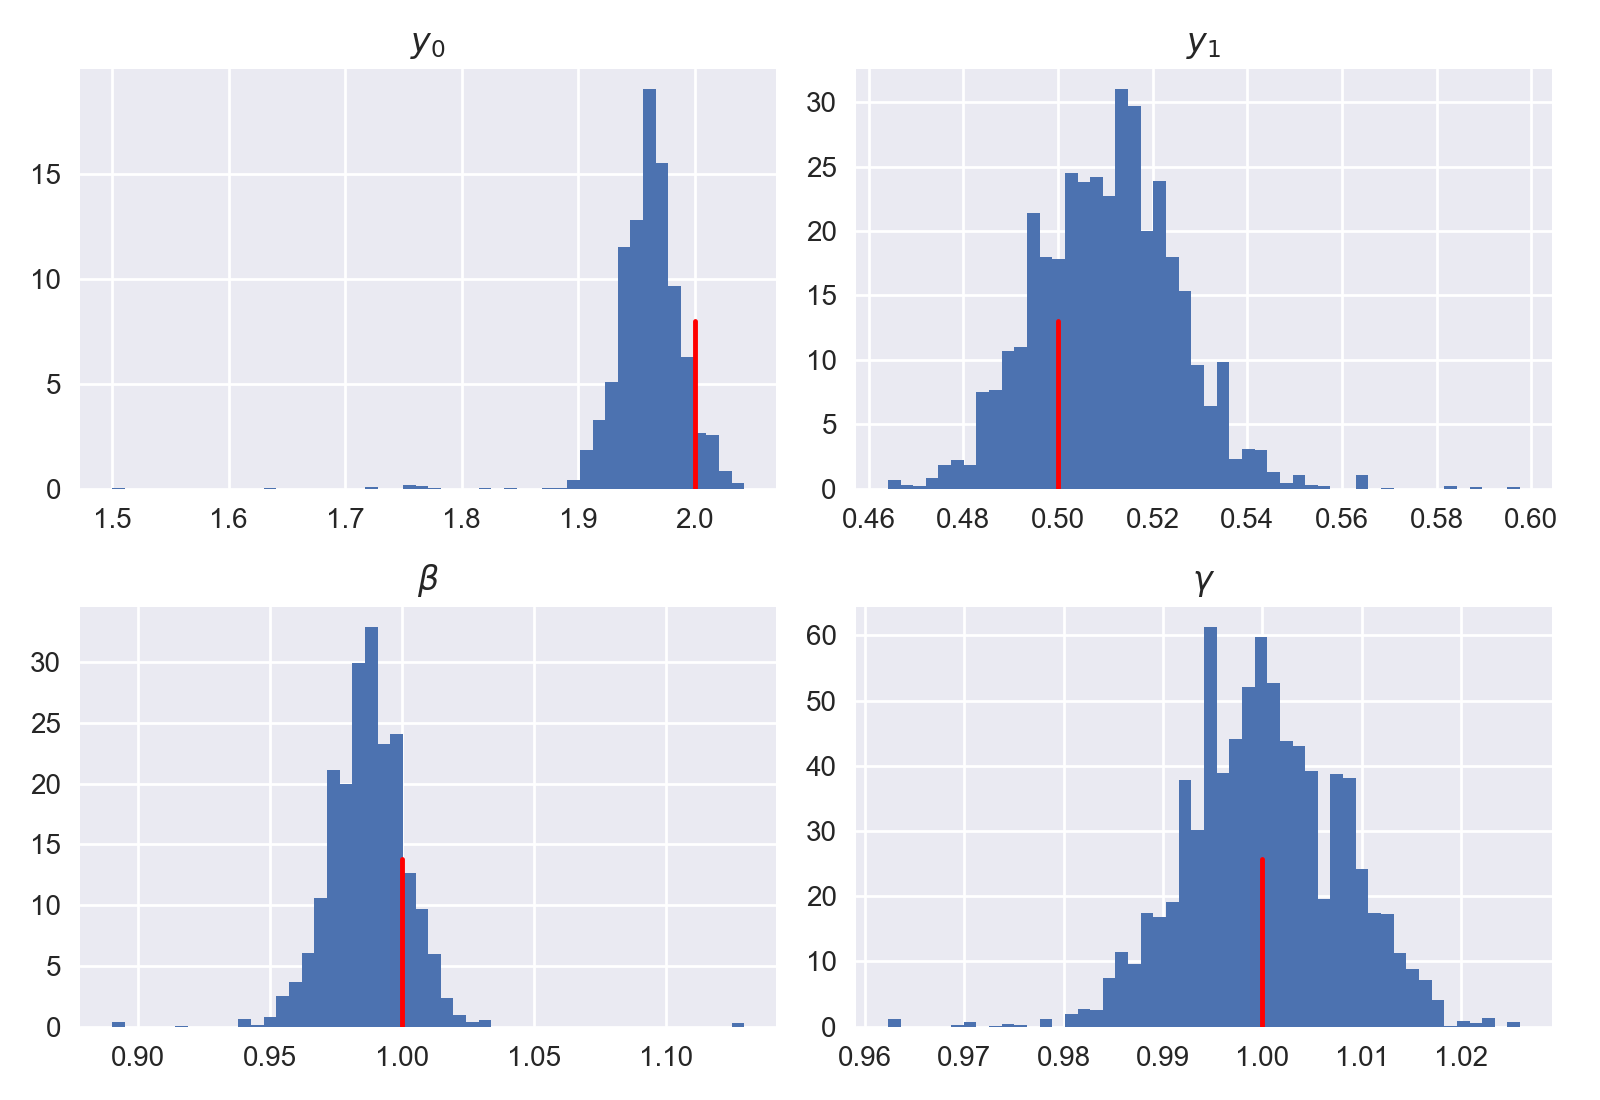

In [179]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


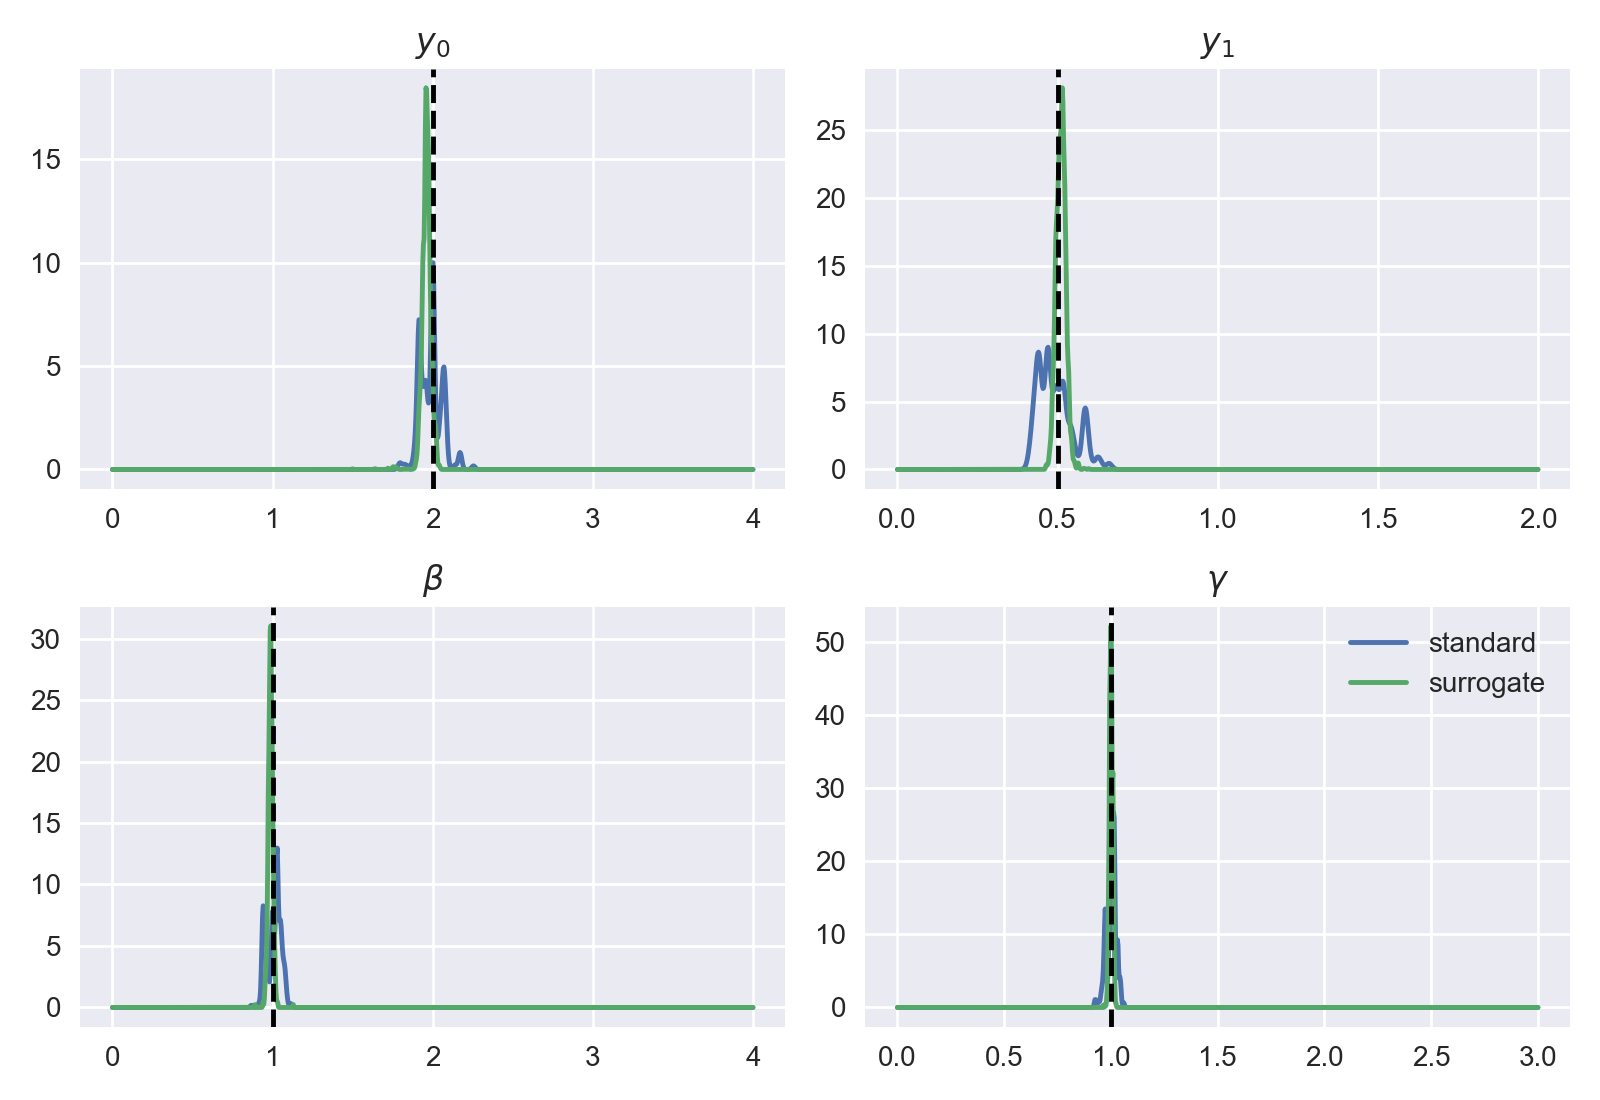

In [193]:
fig = plt.figure()
# y_o
plt.subplot(221)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[0].pdf(x),label='standard')
plt.plot(x,kdes_post[0].pdf(x),label='surrogate')
plt.axvline(2,ls='--',c='k')
plt.title("$y_0$")

# y_1
plt.subplot(222)
x = np.linspace(0,2,1000)
plt.plot(x,kdes_std[1].pdf(x),label='standard')
plt.plot(x,kdes_post[1].pdf(x),label='surrogate')
plt.axvline(.5,ls='--',c='k')
plt.title("$y_1$")

# beta
plt.subplot(223)
x = np.linspace(0,4,1000)
plt.plot(x,kdes_std[2].pdf(x),label='standard')
plt.plot(x,kdes_post[2].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\beta$")

# gamma
plt.subplot(224)
x = np.linspace(0,3,1000)
plt.plot(x,kdes_std[3].pdf(x),label='standard')
plt.plot(x,kdes_post[3].pdf(x),label='surrogate')
plt.axvline(1,ls='--',c='k')
plt.title("$\\gamma$")


plt.tight_layout()
plt.legend()
plt.show()